<a href="https://colab.research.google.com/github/jglaser/gigadocking_notebooks/blob/main/NCATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
project_id = 'cmb-covid19-discovery-collab'

# Mpro

In [3]:
%%bigquery --project $project_id df_assay
SELECT * from mpro_ncats.assay

In [4]:
%%bigquery --project $project_id df_rescore
SELECT *
FROM mpro_ncats.scores
WHERE scores.rank = 0

In [5]:
%%bigquery --project $project_id df_rescore_avg
SELECT name, AVG(rf2) as rf2_avg, MAX(rf2) as rf2_max, 
             AVG(vs_dude_v2) as vs_dude_v2_avg, MAX(vs_dude_v2) AS vs_dude_v2_max,
             AVG(dcoid) as dcoid_avg, MAX(vs_dude_v2) AS dcoid_max
FROM mpro_ncats.scores
GROUP BY name

In [6]:
T = 2.479
q = f"""
SELECT name, STDDEV_SAMP(score) AS score_std, AVG(score) AS score_avg, MIN(score) AS score_min,
        SUM(EXP(-score/{T})*score/{T})/SUM(EXP(-score/{T})) + LOG(AVG(EXP(-score/{T}))) as S_canonical,
        -{T}*LOG(AVG(EXP(-score/{T}))) as F,
FROM mpro_ncats.docked
GROUP BY name
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_score = client.query(q).to_dataframe()

In [7]:
df = df_assay.merge(df_score,left_on='SAMPLE_ID',right_on='name')
df = df.merge(df_rescore,left_on='SAMPLE_ID',right_on='name')
df = df.merge(df_rescore_avg,left_on='SAMPLE_ID',right_on='name')

In [8]:
len(df)

11814

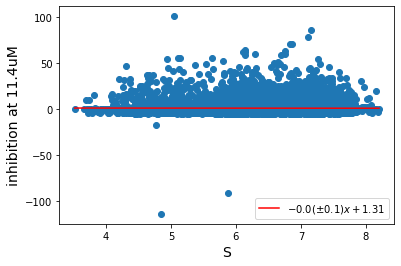

In [9]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
fig, ax = plt.subplots()
idx = 2
x = T*df['S_canonical']
x = df['F']
x = df['rf2']
#x = df['score_avg']
y = -df['DATA'+str(idx)]
#y = df['score_avg']
#y = df['LOG_AC50']
ax.scatter(x,y)
slope, intercept, _, _, stderr = linregress(x[y.notnull()],y[y.notnull()])
x = np.linspace(min(x),max(x),100)
y = slope*x+intercept
ax.plot(x,y,'r',label='${:.1f}(\pm {:.1f}) x+{:.2f}$'.format(slope, stderr, intercept))
ax.legend()
ax.set_xlabel("S",fontsize=14)
ax.set_ylabel("inhibition at {}uM".format(df['CONC{}_M_'.format(idx)].values[0]/1e-6),fontsize=14)
fig.show()

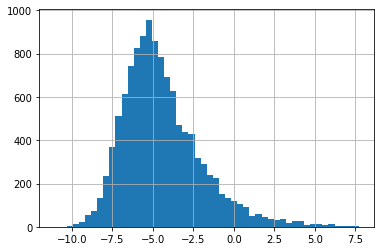

In [ ]:
df['F'].hist(bins=50)

In [10]:
# compute the enrichment
def precision(y_true, y_score, percentage=1):
    sample = y_true[y_score>=np.quantile(y_score, 1-percentage/100)]
    if len(sample) == 0: return np.nan
    return np.count_nonzero(sample)/len(sample)

def precision_neg(y_true, y_score, percentage=1):
    sample = y_true[y_score<=np.quantile(y_score, percentage/100)]
    if len(sample) == 0: return np.nan
    return np.count_nonzero(sample)/len(sample)

def precision2(y_true, y_score, y_score2, percentage=1):
    sample = y_true[(y_score>=np.quantile(y_score, 1-percentage/100)) & (y_score2>=np.quantile(y_score2, 1-percentage/100))]
    if len(sample) == 0: return np.nan
    return np.count_nonzero(sample)/len(sample)

def precision_neg2(y_true, y_score, y_score2, percentage=1):
    sample = y_true[(y_score<=np.quantile(y_score, percentage/100)) & (y_score2<=np.quantile(y_score2, percentage/100))]
    if len(sample) == 0: return np.nan
    return np.count_nonzero(sample)/len(sample)

def recall(y_true, y_score, percentage=1):
    sample = y_true[y_score>=np.quantile(y_score, 1-percentage/100)]
    return np.count_nonzero(sample)/np.count_nonzero(y_true)

def recall2(y_true, y_score, y_score2, percentage=1):
    sample = y_true[(y_score>=np.quantile(y_score, 1-percentage/100)) & (y_score2>=np.quantile(y_score2, 1-percentage/100))]
    return np.count_nonzero(sample)/np.count_nonzero(y_true)

def recall_neg(y_true, y_score, percentage=1):
    sample = y_true[y_score<=np.quantile(y_score, percentage/100)]
    return np.count_nonzero(sample)/np.count_nonzero(y_true)

In [ ]:
np.quantile(df['S_canonical'],0.95)

-0.012254076124746938

In [ ]:
enrichment_factor2(y_true, df.vs_dude_v2_avg, df.rf2_avg, percentage=100)

0.17775520568816658

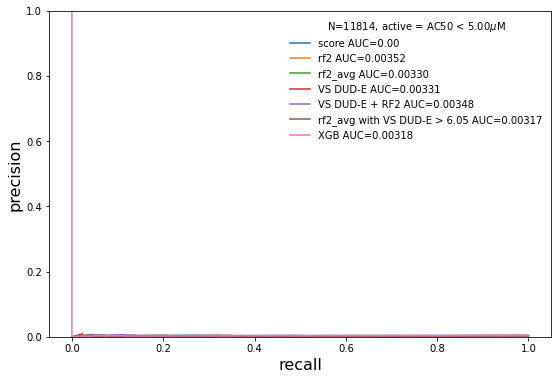

In [ ]:
import numpy as np
x = np.linspace(0,100,100)

cutoff = -50
conc_idx = 1
c = 'DATA'+str(conc_idx)

cutoff = -6 + np.log(5)/np.log(10)
c = 'LOG_AC50'
y_true = df[c] <= cutoff

fig,ax = plt.subplots()
fig.set_size_inches(9,6)


p = [precision_neg(y_true, df.score_avg, percentage=p) for p in x]
r = [recall_neg(y_true, df.score_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='score AUC={:.2f}'.format(auc))

# y = [recall_neg(y_true, df.F, percentage=p) for p in x]
# ax.plot(x,y,label='$F$')

p = [precision(y_true, df.rf2, percentage=p) for p in x]
r = [recall(y_true, df.rf2, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2 AUC={:.5f}'.format(auc))

r = [recall(y_true, df.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, df.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg AUC={:.5f}'.format(auc))

r = [recall(y_true, df.vs_dude_v2, percentage=p) for p in x]
p = [precision(y_true, df.vs_dude_v2, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='VS DUD-E AUC={:.5f}'.format(auc))


r = np.array([recall2(y_true, df.vs_dude_v2_avg, df.rf2_avg, percentage=p) for p in x])
p = np.array([precision2(y_true, df.vs_dude_v2_avg, df.rf2_avg, percentage=p) for p in x])
auc = np.trapz(p[p>0],r[p>0])
ax.plot(r,p,label='VS DUD-E + RF2 AUC={:.5f}'.format(auc))

dude_cutoff = 6.05
filter = df['vs_dude_v2'] > dude_cutoff
r = [recall(y_true, filter*df.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, filter*df.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg with VS DUD-E > {} AUC={:.5f}'.format(dude_cutoff,auc))

X = df[['score_avg','rf2_avg','vs_dude_v2_avg','score_min','rf2_max','vs_dude_v2_max','S_canonical','F']]
prob = model.predict_proba(X)[:,1]
p, r, _ = precision_recall_curve(y_true, prob)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB AUC={:.5f}'.format(auc))

#y = [enrichment_factor_neg(y_true, df.F+T*df.S_canonical, percentage=p) for p in x]
#ax.plot(x,y,label='$\\langle U \\rangle$')

ax.legend(frameon=False,
         title='N={}, active = AC50 < {:.2f}$\mu$M'.format(len(df),
                                                                  10**(cutoff+6)))
                                                                  #-cutoff,
                                                                  #df['CONC{}_M_'.format(conc_idx)].values[0]/1e-6))

ax.set_ylim(0,1)
ax.set_xlabel('recall',fontsize=16)
ax.set_ylabel('precision',fontsize=16)
fig.show()

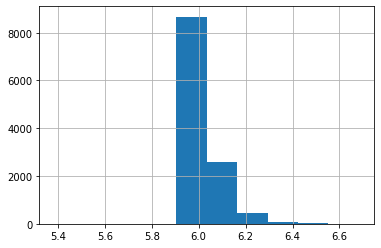

In [ ]:
df['vs_dude_v2'].hist()

# Spike

In [11]:
%%bigquery --project $project_id df_spike_assay
SELECT * from spike_ncats.assay

In [12]:
T = 2.479
q = f"""
SELECT name, STDDEV_SAMP(score) AS score_std, AVG(score) AS score_avg, MIN(score) AS score_min,
        SUM(EXP(-score/{T})*score/{T})/SUM(EXP(-score/{T})) + LOG(AVG(EXP(-score/{T}))) as S_canonical,
        -{T}*LOG(AVG(EXP(-score/{T}))) as F,
FROM spike_ncats.docked
GROUP BY name
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_score = client.query(q).to_dataframe()

In [13]:
%%bigquery --project $project_id df_rescore
SELECT *
FROM spike_ncats.scores
WHERE scores.rank = 0

In [14]:
%%bigquery --project $project_id df_rescore_avg
SELECT name, AVG(rf2) as rf2_avg, MAX(rf2) as rf2_max,
             AVG(vs_dude_v2) as vs_dude_v2_avg, MAX(vs_dude_v2) AS vs_dude_v2_max,
             AVG(dcoid) AS dcoid_avg, MAX(dcoid) AS dcoid_max
FROM spike_ncats.scores
GROUP BY name

In [15]:
df_spike = df_spike_assay.merge(df_score,left_on='SAMPLE_ID',right_on='name')
df_spike = df_spike.merge(df_rescore,left_on='SAMPLE_ID',right_on='name')
df_spike = df_spike.merge(df_rescore_avg,left_on='SAMPLE_ID',right_on='name')

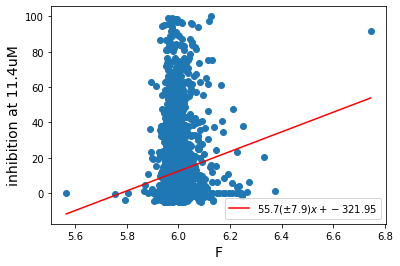

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
fig, ax = plt.subplots()
conc_idx = 5

from scipy.stats import gaussian_kde
ens = gaussian_kde(df_spike['F'],weights=np.exp(-df_spike['F']))
#x = df_spike['F']
#x = T*df_spike['S_canonical']
#x = df_spike['score_min']
#x = np.exp(-df_spike['F'])/np.mean(np.exp(-df_spike['F']))
#x = df_spike['F']-np.average(df_spike['F'],weights=np.exp(-df_spike['F']))
x = df_spike.vs_dude_v2
y = -df_spike['DATA'+str(conc_idx)]
#y = df_spike['score_avg']
#y = ens(df_spike['F'])
#y = df['LOG_AC50']
#y = df_spike['rf2']
ax.scatter(x,y)
slope, intercept, _, _, stderr = linregress(x[y.notnull()],y[y.notnull()])
x = np.linspace(min(x),max(x),100)
y = slope*x+intercept
ax.plot(x,y,'r',label='${:.1f}(\pm {:.1f}) x+{:.2f}$'.format(slope, stderr, intercept))
ax.legend()
ax.set_xlabel("F",fontsize=14)
ax.set_ylabel("inhibition at {}uM".format(df_spike['CONC{}_M_'.format(conc_idx)].values[0]/1e-6),fontsize=14)
fig.show()

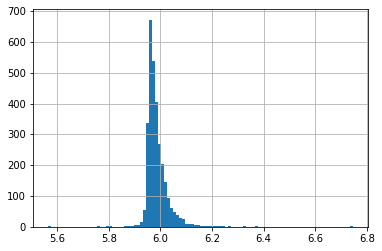

In [ ]:
df_spike['vs_dude_v2'].hist(bins=100)

In [17]:
import xgboost as xgb

In [44]:
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import f1_score

X = df_spike[['score_avg','rf2_avg','vs_dude_v2_avg','score_min','rf2_max','vs_dude_v2_max','S_canonical','F']]
y = df_spike['LOG_AC50'] <  -6 + np.log(5)/np.log(10)

param_dist = {'n_estimators': stats.randint(100, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }

clf_xgb = xgb.XGBClassifier(objective='binary:logistic')
clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 25, scoring = 'f1', error_score = 0, verbose = 3, n_jobs = -1)

numFolds = 5
folds = KFold(n_splits = numFolds, shuffle = True)

estimators = []
results = np.zeros(len(X))
score = 0.0
y_real = []
y_proba = []
for train_index, test_index in folds.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
    clf.fit(X_train, y_train)

    estimators.append(clf.best_estimator_)
    results[test_index] = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)
    y_real.append(y_test)
    y_proba.append(pred_proba[:,1])
    score += f1_score(y_test, results[test_index])
score /= numFolds

# train on entire data set
clf.fit(X,y)
model = clf.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   47.4s finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   43.6s finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   49.8s finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   48.0s finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:   48.8s finished


Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  1.0min finished


In [29]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5292514788688676, gamma=0,
              learning_rate=0.07154097180652505, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=331, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.3308558927403308, verbosity=1)

In [ ]:
active_uM = 5.0
q = f"""
CREATE OR REPLACE MODEL spike_ncats.xgbmodel
OPTIONS(MODEL_TYPE='BOOSTED_TREE_CLASSIFIER',
        DATA_SPLIT_METHOD = 'NO_SPLIT',
        BOOSTER_TYPE = 'GBTREE',
        MIN_TREE_CHILD_WEIGHT = 3,
        MAX_TREE_DEPTH = 8,
        MIN_SPLIT_LOSS=0,
        NUM_PARALLEL_TREE = 1,
        LEARN_RATE=0.06261011091255603,
        MAX_ITERATIONS = 354,
        TREE_METHOD = 'AUTO',
        EARLY_STOP = FALSE,
        SUBSAMPLE = 0.912030456838556,
        COLSAMPLE_BYTREE = 0.7719967928416738,
        INPUT_LABEL_COLS = ['active'])
AS SELECT LOG_AC50 < (-6 + LOG({active_uM})/LOG(10)) AS active,
          score_avg, score_min, S_canonical, F, rf2_avg, rf2_max, vs_dude_v2_avg, vs_dude_v2_max
   FROM spike_ncats.assay
   INNER JOIN ( SELECT docked.name,
          AVG(docked.score) AS score_avg,
          MIN(docked.score) AS score_min,
          SUM(EXP(-docked.score/{T})*docked.score/{T})/SUM(EXP(-docked.score/{T})) + LOG(AVG(EXP(-docked.score/{T}))) as S_canonical,
          -{T}*LOG(AVG(EXP(-docked.score/{T}))) as F,
          AVG(rf2) as rf2_avg,
          MAX(rf2) as rf2_max,
          AVG(vs_dude_v2) as vs_dude_v2_avg,
          MAX(vs_dude_v2) AS vs_dude_v2_max
   FROM spike_ncats.docked
   INNER JOIN spike_ncats.scores ON docked.name = scores.name AND docked.rank = scores.rank
   GROUP BY docked.name
  ) AS A ON assay.SAMPLE_ID = A.name
  WHERE NOT IFNULL(LOG_AC50,0)=0
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
#client.query(q).to_dataframe()

""


In [ ]:
# model = xgb.XGBClassifier(n_estimators=5)
# X = df_spike[['score_avg','rf2_avg','vs_dude_v2_avg','score_min','rf2_max','vs_dude_v2_max','S_canonical','F']].to_numpy()
# Y = df_spike['LOG_AC50'] <  -6 + np.log(5)/np.log(10)
# #X = df_moonshot[['score_avg','rf2_avg','vs_dude_v2_avg','score_min','rf2_max','vs_dude_v2_max','S_canonical','F']].to_numpy()
# #Y = df_moonshot['f_avg_IC50'] <  5
# model.fit(X,Y)

In [25]:
from sklearn.metrics import precision_recall_curve

In [24]:
q = f"""SELECT name, predicted_active_probs[OFFSET(0)].prob AS prob_true FROM ML.PREDICT(MODEL `spike_ncats.xgbmodel`,
    (
    SELECT docked.name, AVG(docked.score) AS score_avg,
          MIN(docked.score) AS score_min,
          SUM(EXP(-docked.score/{T})*docked.score/{T})/SUM(EXP(-docked.score/{T})) + LOG(AVG(EXP(-docked.score/{T}))) as S_canonical,
          -{T}*LOG(AVG(EXP(-docked.score/{T}))) as F,
          AVG(rf2) as rf2_avg,
          MAX(rf2) as rf2_max,
          AVG(vs_dude_v2) as vs_dude_v2_avg,
          MAX(vs_dude_v2) AS vs_dude_v2_max
   FROM spike_ncats.docked
   INNER JOIN spike_ncats.scores ON docked.name = scores.name AND docked.rank = scores.rank
   GROUP BY docked.name
   ))
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_predict = client.query(q).to_dataframe()

In [26]:
df_predict = df_predict.merge(df_spike,on='name')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

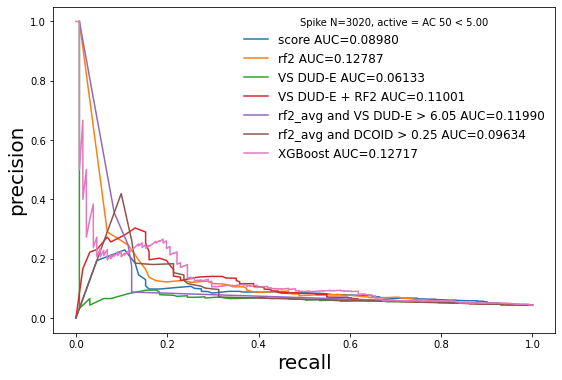

In [70]:
import numpy as np
x = np.linspace(0,100,100)

cutoff = -50
fig, ax = plt.subplots()
fig.set_size_inches(9,6)
conc_idx = 5
c = 'DATA'+str(conc_idx)

cutoff = -6 + np.log(5)/np.log(10)
c = 'LOG_AC50'
y_true = df_spike[c] <= cutoff


# y = [recall(y_true, df_spike.S_canonical, percentage=p) for p in x]
# ax.plot(x,y,label='$S_{\\mathrm{canonical}}$')

p = [precision_neg(y_true, df_spike.score_min, percentage=p) for p in x]
r = [recall_neg(y_true, df_spike.score_min, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='score AUC={:.5f}'.format(auc))

# y = [recall_neg(y_true, df_spike.F, percentage=p) for p in x]
# ax.plot(x,y,label='$F$')

p = [precision(y_true, df_spike.rf2, percentage=p) for p in x]
r = [recall(y_true, df_spike.rf2, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2 AUC={:.5f}'.format(auc))

# r = [recall(y_true, df_spike.rf2_avg, percentage=p) for p in x]
# p = [precision(y_true, df_spike.rf2_avg, percentage=p) for p in x]
# auc = np.trapz(p,r)
# ax.plot(r,p,label='rf2_avg AUC={:.5f}'.format(auc))

r = [recall(y_true, df_spike.vs_dude_v2, percentage=p) for p in x]
p = [precision(y_true, df_spike.vs_dude_v2, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='VS DUD-E AUC={:.5f}'.format(auc))


r = np.array([recall2(y_true, df_spike.vs_dude_v2_avg, df_spike.rf2_avg, percentage=p) for p in x])
p = np.array([precision2(y_true, df_spike.vs_dude_v2_avg, df_spike.rf2_avg, percentage=p) for p in x])
auc = np.trapz(p[p>0],r[p>0])
ax.plot(r,p,label='VS DUD-E + RF2 AUC={:.5f}'.format(auc))


dude_cutoff = 6.05
filter = df_spike['vs_dude_v2'] > dude_cutoff
r = [recall(y_true, filter*df_spike.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, filter*df_spike.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg and VS DUD-E > {} AUC={:.5f}'.format(dude_cutoff,auc))

dcoid_cutoff = 0.25
filter = (df_spike['dcoid_avg'] > dcoid_cutoff)
r = [recall(y_true, filter*df_spike.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, filter*df_spike.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg and DCOID > {} AUC={:.5f}'.format(dcoid_cutoff,auc))

p, r, _ = precision_recall_curve(np.concatenate(y_real), np.concatenate(y_proba))
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGBoost AUC={:.5f}'.format(auc))

# y_true = df_predict[c] <= cutoff
# prob = df_predict.prob_true
# p, r, _ = precision_recall_curve(y_true, prob)
# auc = np.trapz(p[::-1],r[::-1])
# ax.plot(r,p,label='BQ XGB AUC={:.5f}'.format(auc))

ax.legend(frameon=False, ncol=1,
          title='Spike N={}, active = AC 50 < {:.2f}'.format(len(df_spike),
                                                                10**(cutoff+6),
                                                                df_spike['CONC{}_M_'.format(conc_idx)].values[0]/1e-6),
          prop={'size': 12})

ax.set_xlabel('recall',fontsize=20)
ax.set_ylabel('precision',fontsize=20)
fig.savefig('spike_pr.pdf')
#from google.colab import files
#files.download('spike_pr.pdf')
fig.show()

## Moonshot

In [31]:
%%bigquery --project $project_id df_moonshot_assay
SELECT * from moonshot.activities

In [32]:
%%bigquery --project $project_id df_moonshot_rescore
SELECT *
FROM moonshot.scores
WHERE scores.rank = 0

In [33]:
%%bigquery --project $project_id df_moonshot_rescore_avg
SELECT name, AVG(rf2) as rf2_avg, MAX(rf2) as rf2_max, AVG(vs_dude_v2) as vs_dude_v2_avg, MAX(vs_dude_v2) AS vs_dude_v2_max
FROM moonshot.scores
GROUP BY name

In [34]:
T = 2.479
q = f"""
SELECT name, STDDEV_SAMP(score) AS score_std, AVG(score) AS score_avg, MIN(score) AS score_min,
        SUM(EXP(-score/{T})*score/{T})/SUM(EXP(-score/{T})) + LOG(AVG(EXP(-score/{T}))) as S_canonical,
        -{T}*LOG(AVG(EXP(-score/{T}))) as F,
FROM moonshot.docked
GROUP BY name
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_moonshot_score = client.query(q).to_dataframe()

In [35]:
df_moonshot = df_moonshot_assay.merge(df_moonshot_score,left_on='CID',right_on='name')
df_moonshot = df_moonshot.merge(df_moonshot_rescore,left_on='CID',right_on='name')
df_moonshot = df_moonshot.merge(df_moonshot_rescore_avg,left_on='CID',right_on='name')

In [36]:
len(df_moonshot)

1688

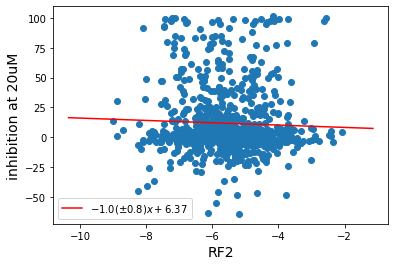

In [37]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
fig, ax = plt.subplots()
idx = 2
#x = df_moonshot['rf2']
#x = df['score_avg']
x = df_moonshot['F']
y = df_moonshot['f_inhibition_at_20_uM']
#y = df['score_avg']
#y = df['LOG_AC50']
ax.scatter(x,y)
slope, intercept, _, _, stderr = linregress(x[y.notnull()],y[y.notnull()])
x = np.linspace(min(x),max(x),100)
y = slope*x+intercept
ax.plot(x,y,'r',label='${:.1f}(\pm {:.1f}) x+{:.2f}$'.format(slope, stderr, intercept))
ax.legend()
ax.set_xlabel("RF2",fontsize=14)
ax.set_ylabel("inhibition at 20uM",fontsize=14)
fig.show()

In [38]:
q = f"""SELECT name, predicted_active_probs[OFFSET(0)].prob AS prob_true FROM ML.PREDICT(MODEL `spike_ncats.xgbmodel`,
    (
    SELECT docked.name, AVG(docked.score) AS score_avg,
          MIN(docked.score) AS score_min,
          SUM(EXP(-docked.score/{T})*docked.score/{T})/SUM(EXP(-docked.score/{T})) + LOG(AVG(EXP(-docked.score/{T}))) as S_canonical,
          -{T}*LOG(AVG(EXP(-docked.score/{T}))) as F,
          AVG(rf2) as rf2_avg,
          MAX(rf2) as rf2_max,
          AVG(vs_dude_v2) as vs_dude_v2_avg,
          MAX(vs_dude_v2) AS vs_dude_v2_max
   FROM moonshot.docked
   INNER JOIN moonshot.scores ON docked.name = scores.name AND docked.rank = scores.rank
   GROUP BY docked.name
   ))
"""
from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_predict = client.query(q).to_dataframe()

In [39]:
df_predict = df_predict.merge(df_moonshot,on='name')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

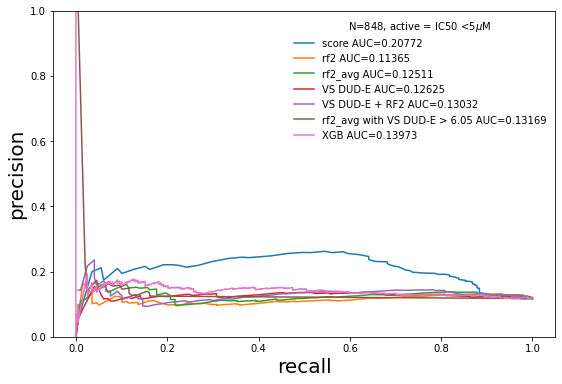

In [81]:
import numpy as np
x = np.linspace(0,100,100)

#cutoff = 50
#c = 'f_inhibition_at_20_uM'

cutoff = 5
c = 'f_avg_IC50'
y_true = (df_moonshot[c] <= cutoff)

fig,ax = plt.subplots()
fig.set_size_inches(9,6)


p = [precision_neg(y_true, df_moonshot.score_min, percentage=p) for p in x]
r = [recall_neg(y_true, df_moonshot.score_min, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='score AUC={:.5f}'.format(auc))

# p = [precision(y_true, df_moonshot.S_canonical, percentage=p) for p in x]
# r = [recall(y_true, df_moonshot.S_canonical, percentage=p) for p in x]
# auc = np.trapz(p,r)
# ax.plot(r,p,label='$S$ AUC={:.5f}'.format(auc))

p = [precision(y_true, df_moonshot.rf2, percentage=p) for p in x]
r = [recall(y_true, df_moonshot.rf2, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2 AUC={:.5f}'.format(auc))

r = [recall(y_true, df_moonshot.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, df_moonshot.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg AUC={:.5f}'.format(auc))

r = [recall(y_true, df_moonshot.vs_dude_v2, percentage=p) for p in x]
p = [precision(y_true, df_moonshot.vs_dude_v2, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='VS DUD-E AUC={:.5f}'.format(auc))


r = np.array([recall2(y_true, df_moonshot.vs_dude_v2_avg, df_moonshot.rf2_avg, percentage=p) for p in x])
p = np.array([precision2(y_true, df_moonshot.vs_dude_v2_avg, df_moonshot.rf2_avg, percentage=p) for p in x])
auc = np.trapz(p[p>0],r[p>0])
ax.plot(r,p,label='VS DUD-E + RF2 AUC={:.5f}'.format(auc))

dude_cutoff = 6.05
filter = df_moonshot['vs_dude_v2'] > dude_cutoff
r = [recall(y_true, filter*df_moonshot.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, filter*df_moonshot.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg with VS DUD-E > {} AUC={:.5f}'.format(dude_cutoff,auc))


X = df_moonshot[['score_avg','rf2_avg','vs_dude_v2_avg','score_min','rf2_max','vs_dude_v2_max','S_canonical','F']]
prob = model.predict_proba(X)[:,1]
p, r, _ = precision_recall_curve(y_true, prob)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB AUC={:.5f}'.format(auc))


# y_true = df_predict[c] <= cutoff
# prob = df_predict.prob_true
# p, r, _ = precision_recall_curve(y_true, prob)
# auc = np.trapz(p[::-1],r[::-1])
# ax.plot(r,p,label='BQ XGB AUC={:.5f}'.format(auc))

# dude_cutoff = 6
# filter = df_moonshot['vs_dude_v2'] > dude_cutoff
# y = [enrichment_factor(y_true[filter], df_moonshot[filter].rf2_avg, percentage=p) for p in x]
# ax.plot(x,y,label='rf2_avg with VS DUD-E > {}'.format(dude_cutoff))

# y = [enrichment_factor_neg(y_true, df_moonshot.F+T*df_moonshot.S_canonical, percentage=p) for p in x]
# ax.plot(x,y,label='$\\langle U \\rangle$')

ax.legend(frameon=False,ncol=1,
         title='N={}, active = IC50 <{}$\\mu$M'.format(len(df_moonshot[df_moonshot[c].notnull()]),cutoff))

ax.set_ylim(0,1)
ax.set_xlabel('recall',fontsize=20)
ax.set_ylabel('precision',fontsize=20)
fig.savefig('mpro_postera_pr.pdf')
from google.colab import files
files.download('mpro_postera_pr.pdf')
fig.show()

In [ ]:
np.count_nonzero(pred), np.count_nonzero(y_true)

(93, 198)

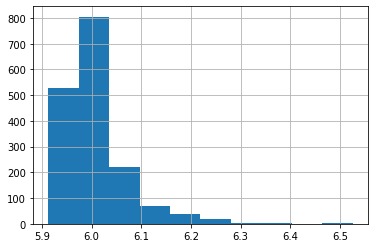

In [ ]:
df_moonshot['vs_dude_v2'].hist()

# Primary screen

In [ ]:
q = f"""
SELECT * FROM
(
  SELECT name_first, AVG(rf2) AS rf2_avg, MAX(rf2) AS rf2_max,
    AVG(vs_dude_v2) AS vs_dude_v2_avg, MAX(vs_dude_v2) AS vs_dude_v2_max,
    AVG(dcoid) AS dcoid_avg, MAX(dcoid) AS dcoid_max,
    AVG(score) AS score_avg, MIN(score) AS score_min,
    SUM(EXP(-score/{T})*score/{T})/SUM(EXP(-score/{T})) + LOG(AVG(EXP(-score/{T}))) as S_canonical,
    -{T}*LOG(AVG(EXP(-score/{T}))) as F,
  FROM  (SELECT *,SPLIT(name,"_")[OFFSET(0)] as name_first FROM `cmb-covid19-discovery-collab.mpro_5r84.scores` WHERE score < 0)
  GROUP BY name_first
) AS A RIGHT JOIN mpro_exp.primary_screen_sep_2020 AS B ON A.name_first = B.compound"""

from google.cloud import bigquery
client = bigquery.Client(project=project_id)
df_primary = client.query(q).to_dataframe()

In [ ]:
df_primary_nn = df_primary[~df_primary.score_avg.isna()]

In [50]:
import numpy as np
x = np.linspace(0,100,100)

cutoff = 65
c = '__residual_activity'
y_true = (df_primary_nn[c] <= cutoff)

fig,ax = plt.subplots()
fig.set_size_inches(9,6)


p = [precision_neg(y_true, df_primary_nn.score_avg, percentage=p) for p in x]
r = [recall_neg(y_true, df_primary_nn.score_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='score AUC={:.5f}'.format(auc))

# p = [precision(y_true, df_primary.S_canonical, percentage=p) for p in x]
# r = [recall(y_true, df_primary.S_canonical, percentage=p) for p in x]
# auc = np.trapz(p,r)
# ax.plot(r,p,label='$S$ AUC={:.5f}'.format(auc))

# p = [precision(y_true, df_primary.rf2, percentage=p) for p in x]
# r = [recall(y_true, df_primary.rf2, percentage=p) for p in x]
# auc = np.trapz(p,r)
# ax.plot(r,p,label='rf2 AUC={:.5f}'.format(auc))

r = [recall(y_true, df_primary_nn.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, df_primary_nn.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg AUC={:.5f}'.format(auc))

r = [recall(y_true, df_primary_nn.vs_dude_v2_avg, percentage=p) for p in x]
p = [precision(y_true, df_primary_nn.vs_dude_v2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='VS DUD-E AUC={:.5f}'.format(auc))


r = np.array([recall2(y_true, df_primary_nn.vs_dude_v2_avg, df_primary_nn.rf2_avg, percentage=p) for p in x])
p = np.array([precision2(y_true, df_primary_nn.vs_dude_v2_avg, df_primary_nn.rf2_avg, percentage=p) for p in x])
auc = np.trapz(p[p>0],r[p>0])
ax.plot(r,p,label='VS DUD-E + RF2 AUC={:.5f}'.format(auc))

dude_cutoff = 6.05
filter = df_primary_nn['vs_dude_v2'] > dude_cutoff
r = [recall(y_true, filter*df_primary_nn.rf2_avg, percentage=p) for p in x]
p = [precision(y_true, filter*df_primary_nn.rf2_avg, percentage=p) for p in x]
auc = np.trapz(p,r)
ax.plot(r,p,label='rf2_avg with VS DUD-E > {} AUC={:.5f}'.format(dude_cutoff,auc))


X = df_primary_nn[['score_avg','rf2_avg','vs_dude_v2_avg','score_min','rf2_max','vs_dude_v2_max','S_canonical','F']]
prob = model.predict_proba(X)[:,1]
p, r, _ = precision_recall_curve(y_true, prob)
auc = np.trapz(p[::-1],r[::-1])
ax.plot(r,p,label='XGB AUC={:.5f}'.format(auc))

# dude_cutoff = 6
# filter = df_primary['vs_dude_v2'] > dude_cutoff
# y = [enrichment_factor(y_true[filter], df_primary[filter].rf2_avg, percentage=p) for p in x]
# ax.plot(x,y,label='rf2_avg with VS DUD-E > {}'.format(dude_cutoff))

# y = [enrichment_factor_neg(y_true, df_primary.F+T*df_primary.S_canonical, percentage=p) for p in x]
# ax.plot(x,y,label='$\\langle U \\rangle$')

ax.legend(frameon=False,ncol=2,
         title='N={}, active = IC50 <{}$\\mu$M'.format(len(df_primary[df_primary[c].notnull()]),cutoff))

ax.set_ylim(0,1)
ax.set_xlabel('recall',fontsize=16)
ax.set_ylabel('precision',fontsize=16)
fig.show()

NameError: ignored

In [ ]:
np.count_nonzero(pred)

93